In [3]:
import sys
import os
os.environ['USE_PYGEOS'] = '0'
import gc
import collections

import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams, cycler
from matplotlib import animation, rc
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import geopandas as gpd

import numpy as np
import xarray as xr
# from xeofs.xarray import EOF
import rioxarray

import dask

import scipy
from scipy import signal
import cftime
from shapely.geometry import mapping
from xarrayutils.utils import linear_trend, xr_linregress
import pandas as pd

In [4]:
# File path directories

inDirName = '/Users/smurugan9/research/aislens/aislens_emulation/'
DIR_external = 'data/external/'
DIR_interim = 'data/interim/'

# DATASET FILEPATHS
# Basal melt observations from Paolo 2023
DIR_basalMeltObs = 'data/external/Paolo2023/'
# Ocean model output - E3SM (SORRMv2.1.ISMF), data received from Darin Comeau / Matt Hoffman at LANL
DIR_SORRMv21 = 'data/external/SORRMv2.1.ISMF/regridded_output/'

# INTERIM GENERATED FILEPATHS
DIR_basalMeltObs_Interim = 'data/interim/Paolo2023/iceShelves_dedraft/'
DIR_SORRMv21_Interim = 'data/interim/SORRMv2.1.ISMF/iceShelves_dedraft/'

# DATA FILENAMES
FILE_basalMeltObs = 'ANT_G1920V01_IceShelfMelt.nc'
FILE_MeltDraftObs = 'ANT_G1920V01_IceShelfMeltDraft.nc'
FILE_SORRMv21 = 'Regridded_SORRMv2.1.ISMF.FULL.nc'


FILE_iceShelvesShape = 'iceShelves.geojson'

In [24]:
MELTDRAFT_OBS = xr.open_dataset(inDirName+DIR_basalMeltObs+FILE_MeltDraftObs)
SORRMv21 = xr.open_dataset(inDirName+DIR_SORRMv21+FILE_SORRMv21, chunks={"Time":36})

ICESHELVES_MASK = gpd.read_file(inDirName+DIR_external+FILE_iceShelvesShape)
icems = ICESHELVES_MASK.to_crs({'init': 'epsg:3031'});
crs = ccrs.SouthPolarStereo();

/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [14]:
# Linear trend, if any
def detrend_dim(data, dim, deg):
    # detrend along a single dimension
    p = data.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(data[dim], p.polyfit_coefficients)
    return data - fit

In [22]:
# Remove linear trend from the deseasonalized anomalies
SORRMv21_flux_detrended = detrend_dim(SORRMv21.timeMonthly_avg_landIceFreshwaterFlux, 'Time', 1)

In [17]:
SORRMv21_flux_detrended.to_netcdf(inDirName+DIR_SORRMv21+FILE_SORRMv21+"SORRMv21_flux_detrended.nc")
SORRMv21_flux_detrended_ts = SORRMv21_flux_detrended.sum(["x","y"]).compute()

In [6]:
flux_clean = xr.open_dataset(inDirName+
                             DIR_interim+
                             "SORRMv2.1.ISMF/600y/flux_clean_600y.nc",
                            chunks={"Time":100})

In [7]:
flux_clean = flux_clean.rename({"__xarray_dataarray_variable__":"flux_clean"})

In [8]:
flux_clean.flux_clean.sum(["x","y"])

<xarray.DataArray 'flux_clean' (Time: 7200)>
dask.array<sum-aggregate, shape=(7200,), dtype=float64, chunksize=(100,), chunktype=numpy.ndarray>
Coordinates:
  * Time     (Time) object 0301-01-16 12:00:00.000001 ... 0900-12-16 12:00:00...

In [9]:
flux_clean_ts = flux_clean.sum(['x','y'])

In [11]:
sec_per_yr = 3*1e7
#MELTOBS = MELTDRAFT_OBS.melt*1000/sec_per_yr

In [15]:
melt_clean_ts = flux_clean_ts*sec_per_yr*100e6/1000

In [13]:
sorrmv21_ts = SORRMv21.timeMonthly_avg_landIceFreshwaterFlux.mean(['x','y'])

NameError: name 'SORRMv21' is not defined

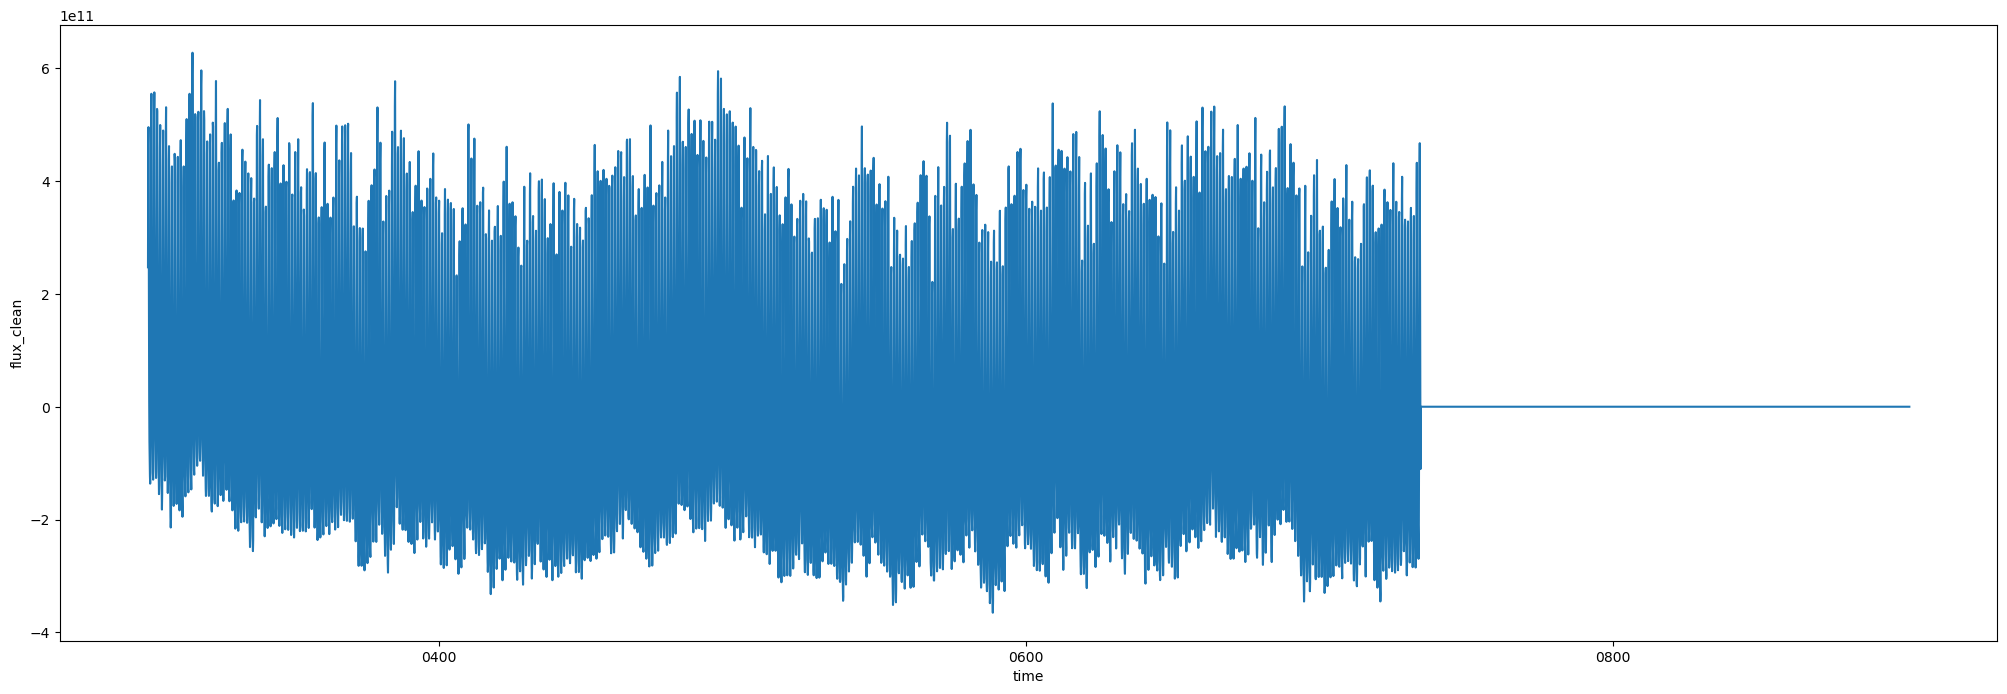

In [18]:
ax = plt.figure(figsize=(25,8))
melt_clean_ts.flux_clean.plot(label='SORRMv2.1 FreshwaterFlux (spatially aggregated)')

In [23]:
flux_clean.to_netcdf(inDirName+DIR_interim+"SORRMv2.1.ISMF/600y/flux_clean_600y.nc")

RuntimeError: NetCDF: HDF error

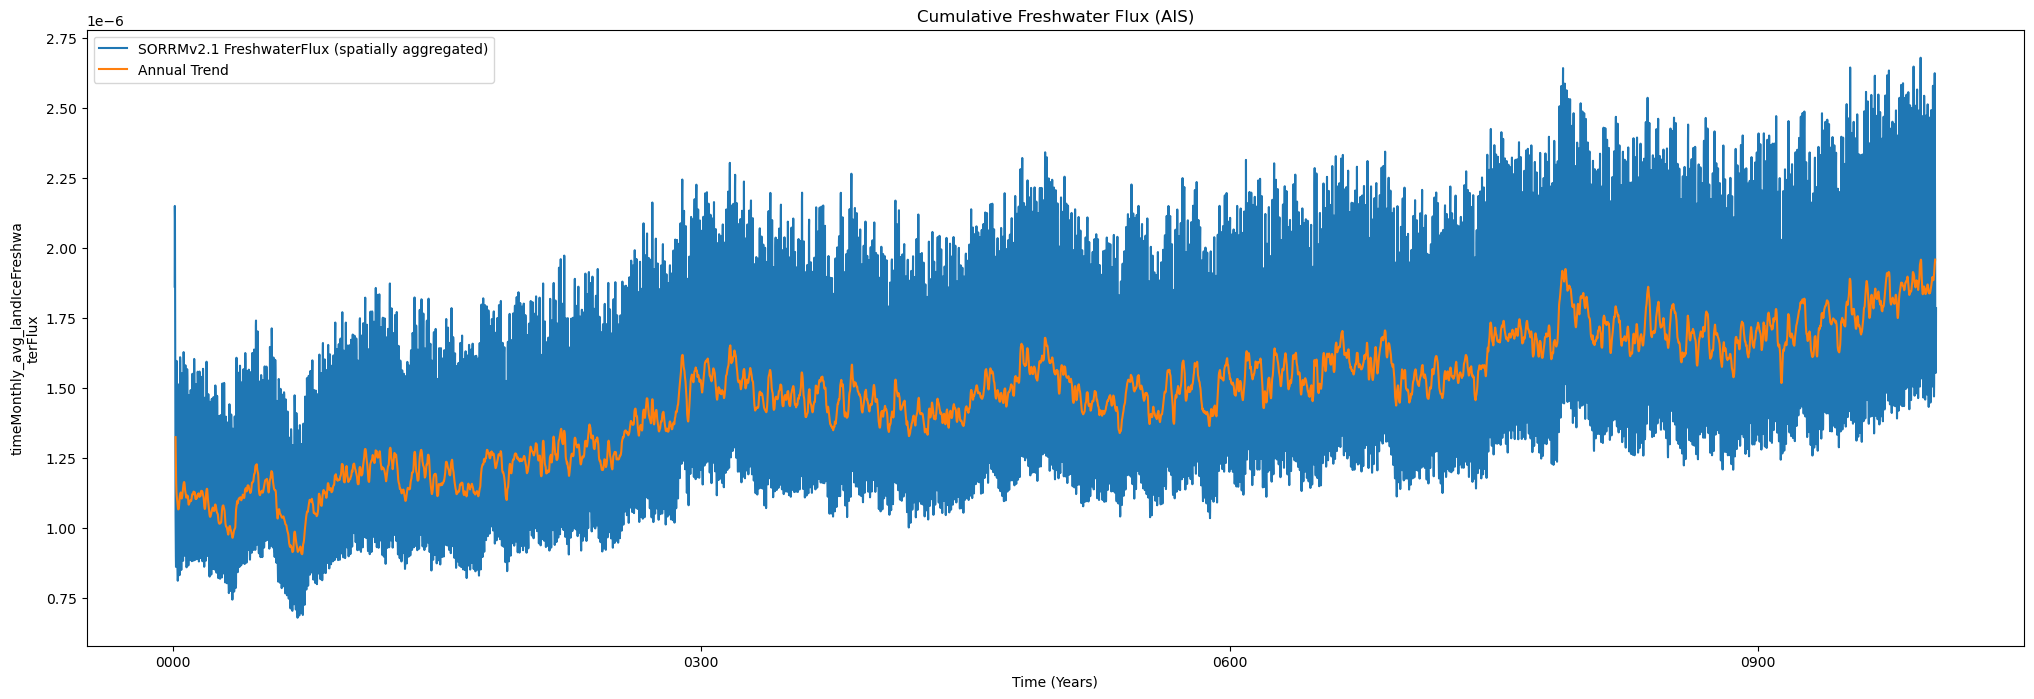

In [37]:
"""
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(sorrmv21_ts, period=12)
ax = plt.figure(figsize=(25,8))
sorrmv21_ts.plot(label='SORRMv2.1 FreshwaterFlux (spatially aggregated)')
plt.plot(sorrmv21_ts.Time,result.trend, label='Annual Trend')
plt.xlabel('Time (Years)')
plt.title('Cumulative Freshwater Flux (AIS)')
plt.legend()
plt.savefig(inDirName+'reports/interim-fig/SORRMv2.1.ISMF/SORRMv2.1.ISMF.TimeSeries.png')
"""

In [19]:
SORRMv21.rio.write_crs("epsg:3031",inplace=True);
#h = SORRMv21.timeMonthly_avg_ssh
h_mean = SORRMv21.timeMonthly_avg_ssh.mean('Time')

In [12]:
MELTOBS_TS = (MELTOBS*3*3*1e6).sum(['x','y'])

In [14]:

# Deseasonalize
# Remove climatologies to isolate anomalies / deseasonalize 
flux_month = MELTOBS_TS.groupby("time.month")
flux_clm = flux_month.mean("time") # Climatologies
flux_anm = flux_month - flux_clm # Deseasonalized anomalies

In [8]:
MELTDRAFT_OBS.rio.write_crs("epsg:3031",inplace=True);
h = MELTDRAFT_OBS.draft
h_mean = h.mean('time')

In [4]:
def clip_data(DATA, iceShelfMask_index):
    masked_data = DATA.rio.clip(icems.loc[[iceShelfMask_index],'geometry'].apply(mapping), icems.crs, drop=False)
    return masked_data

In [ ]:
for i in range(6,32):
    print('extracting data for catchment {}'.format(icems.name.values[i]))
    mlt = xr.DataArray(np.empty(SORRMv21.timeMonthly_avg_landIceFreshwaterFlux.shape),
                       dims = SORRMv21.timeMonthly_avg_landIceFreshwaterFlux.dims,
                       coords = SORRMv21.timeMonthly_avg_landIceFreshwaterFlux.coords,
                       attrs = SORRMv21.timeMonthly_avg_landIceFreshwaterFlux.attrs)
    for j in range(SORRMv21.Time.shape[0]):
        mlt[j] = clip_data(SORRMv21.timeMonthly_avg_landIceFreshwaterFlux[j], i)
    mlt_mean = mlt.mean('Time')
    # Dedraft: Linear Regression with SSH over chosen basin
    print('calculating linear regression for catchment {}'.format(icems.name.values[i]))
    mlt_rgrs = xr_linregress(h, mlt_mean, dim='Time') # h = independent variable
    mlt_prd = mlt_rgrs.slope*h_mean + mlt_rgrs.intercept
    #flx_ddrft = flx - flx_prd
    mlt_prd.to_netcdf(inDirName+DIR_SORRMv21_Interim+'{}_rgrs.nc'.format(icems.name.values[i]))
    print('{} file saved'.format(icems.name.values[i]))
    del mlt, mlt_mean, mlt_rgrs, mlt_prd
    print('deleted interim variables')
    gc.collect()

extracting data for catchment IMBIE1


In [23]:
icems.loc[[32],'name']

32    IMBIE27
Name: name, dtype: object

In [24]:
for i in range(32,33):
    print('extracting data for catchment {}'.format(icems.name.values[i]))
    mlt = MELTDRAFT_OBS.melt.rio.clip(icems.loc[[i],'geometry'].apply(mapping),icems.crs,drop=False)
    mlt_mean = mlt.mean('time')
    #h = ds.timeMonthly_avg_ssh
    #h_mean = h.mean('time')
    # Dedraft: Linear Regression with SSH over chosen basin
    print('calculating linear regression for catchment {}'.format(icems.name.values[i]))
    mlt_rgrs = xr_linregress(h, mlt_mean, dim='time') # h = independent variable
    mlt_rgrs.to_netcdf(inDirName+DIR_basalMeltObs_Interim+'{}_rgrs_vals.nc'.format(icems.name.values[i]))
    #flx_ddrft = flx - flx_prd
    mlt_prd.to_netcdf(inDirName+DIR_basalMeltObs_Interim+'{}_rgrs.nc'.format(icems.name.values[i]))
    #print('{} file saved'.format(icems.name.values[i]))
    del mlt, mlt_mean, mlt_rgrs, mlt_prd
    print('finished')
    #gc.collect()

extracting data for catchment IMBIE27
calculating linear regression for catchment IMBIE27
finished


In [27]:
# Merge regression files of individual ice shelves

ds_np = np.empty(MELTDRAFT_OBS.melt[0].shape)
ds_np[:] = np.nan

ICESHELF_RGRS = xr.DataArray(ds_np, 
                             coords=MELTDRAFT_OBS.melt[0].coords, 
                             dims = MELTDRAFT_OBS.melt[0].dims, 
                             attrs=MELTDRAFT_OBS.melt.attrs)
#iceshelves_rgrs = xr.Dataset(data_vars=dict(timeMonthly_avg_landIceFreshwaterFlux=(iceshelves_rgrs_array)), coords=data.coords, attrs=data.timeMonthly_avg_landIceFreshwaterFlux.attrs)
ICESHELF_RGRS = xr.Dataset(data_vars=dict(melt=(ICESHELF_RGRS)))

for i in range(6,33):
    iceshelves_rgrs_catchment = xr.open_dataset(inDirName+DIR_basalMeltObs_Interim+'{}_rgrs.nc'.format(icems.name.values[i]))
    iceshelves_rgrs_catchment['melt'] = iceshelves_rgrs_catchment['__xarray_dataarray_variable__']
    iceshelves_rgrs_catchment = iceshelves_rgrs_catchment.drop(['__xarray_dataarray_variable__'])
    ICESHELF_RGRS = xr.merge([ICESHELF_RGRS, iceshelves_rgrs_catchment], compat='no_conflicts')

ICESHELF_RGRS.to_netcdf(inDirName+DIR_basalMeltObs_Interim+"ICESHELVES_AIS_RGRS.nc")

In [32]:
# Merge regression files of individual ice shelves

ds_np = np.empty(SORRMv21.timeMonthly_avg_landIceFreshwaterFlux[0].shape)
ds_np[:] = np.nan

ICESHELF_RGRS = xr.DataArray(ds_np, 
                             coords=SORRMv21.timeMonthly_avg_landIceFreshwaterFlux[0].coords, 
                             dims = SORRMv21.timeMonthly_avg_landIceFreshwaterFlux[0].dims, 
                             attrs=SORRMv21.timeMonthly_avg_landIceFreshwaterFlux.attrs)
#iceshelves_rgrs = xr.Dataset(data_vars=dict(timeMonthly_avg_landIceFreshwaterFlux=(iceshelves_rgrs_array)), coords=data.coords, attrs=data.timeMonthly_avg_landIceFreshwaterFlux.attrs)
ICESHELF_RGRS = xr.Dataset(data_vars=dict(timeMonthly_avg_landIceFreshwaterFlux=(ICESHELF_RGRS)))

for i in range(6,33):
    iceshelves_rgrs_catchment = xr.open_dataset(inDirName+DIR_SORRMv21_Interim+'{}_rgrs.nc'.format(icems.name.values[i]))
    iceshelves_rgrs_catchment['timeMonthly_avg_landIceFreshwaterFlux'] = iceshelves_rgrs_catchment['__xarray_dataarray_variable__']
    iceshelves_rgrs_catchment = iceshelves_rgrs_catchment.drop(['__xarray_dataarray_variable__'])
    ICESHELF_RGRS = xr.merge([ICESHELF_RGRS, iceshelves_rgrs_catchment], compat='no_conflicts')

ICESHELF_RGRS.to_netcdf(inDirName+DIR_SORRMv21_Interim+"ICESHELVES_AIS_RGRS.nc")

# Dedraft data

DEDRAFTED_SORRM = SORRMv21.timeMonthly_avg_landIceFreshwaterFlux - ICESHELF_RGRS.timeMonthly_avg_landIceFreshwaterFlux
DEDRAFTED_SORRM = xr.Dataset(data_vars=dict(timeMonthly_avg_landIceFreshwaterFlux=(DEDRAFTED_SORRM)))
DEDRAFTED_SORRM.to_netcdf(inDirName+DIR_interim+"SORRMv2.1./DEDRAFTED_SORRM.nc")

In [33]:
# Dedraft data

DEDRAFTED_MELT_OBS = MELTDRAFT_OBS.melt - ICESHELF_RGRS.melt
DEDRAFTED_MELT_OBS = xr.Dataset(data_vars=dict(melt=(DEDRAFTED_MELT_OBS)))
DEDRAFTED_MELT_OBS.to_netcdf(inDirName+DIR_interim+"Paolo2023/DEDRAFTED_MELT_OBS.nc")

In [47]:
MELTDRAFT_OBS.melt.attrs

{'units': 'm of ice per year',
 'standard_name': 'ice shelf basal melt rate',
 'density': 917.0,
 'density_units': 'kg m^-3',
 'grid_mapping': 'mapping'}

In [34]:
# m / yr
sec_per_yr = 60*60*24*365
rho_ice = 917.0 # kg/m^3
rho_fw = 1000.0 
#MELTDRAFT_MELTOBS = MELTDRAFT_OBS.melt*rho_fw/sec_per_yr

In [5]:
DEDRAFTED_MELT_OBS = xr.open_dataset(inDirName+DIR_interim+"Paolo2023/DEDRAFTED_MELT_OBS.nc")
DEDRAFTED_MELT = DEDRAFTED_MELT_OBS.melt*rho_fw/sec_per_yr
DEDRAFTED_MELT.rio.write_crs("epsg:3031",inplace=True);

In [155]:
obs23 = MELTDRAFT_OBS.melt*1000/sec_per_yr

In [160]:
obs23.mean()

<xarray.DataArray 'melt' ()>
array(-2.15024401e-05)

In [10]:
DEDRAFTED_SORRM = xr.open_dataset(inDirName+DIR_interim+"SORRMv2.1.ISMF/DEDRAFTED_SORRM.nc")
#DEDRAFTED_MELT = DEDRAFTED_SORRM.t
#DEDRAFTED_MELT.rio.write_crs("epsg:3031",inplace=True);

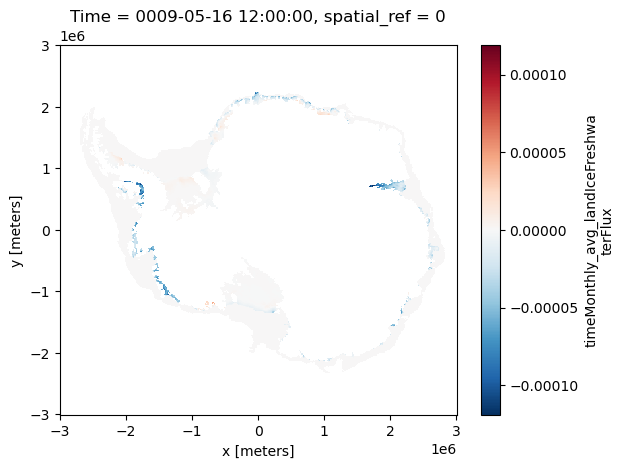

In [13]:
DEDRAFTED_SORRM.timeMonthly_avg_landIceFreshwaterFlux[100].plot()

In [31]:
ICESHELVES_AIS_RGRS = xr.open_dataset(inDirName+DIR_SORRMv21_Interim+"ICESHELVES_AIS_RGRS.nc")
ICESHELVES_AIS_RGRS.timeMonthly_avg_landIceFreshwaterFlux

ds_np = np.empty(len(range(6,33)))
ds_np[:] = np.nan

for i,isnum in enumerate(range(6,33)):
    ICESHELF_MELT = ICESHELVES_AIS_RGRS.timeMonthly_avg_landIceFreshwaterFlux.rio.clip(icems.loc[[isnum],'geometry'].apply(mapping),icems.crs,drop=False)
    ds_np[i] = ICESHELF_MELT.mean()
    print("calculated for {}".format(icems.name.values[isnum]))
    #iceshelves_rgrs_catchment = iceshelves_rgrs_catchment.drop(['__xarray_dataarray_variable__'])
    #ICESHELF_RGRS = xr.merge([ICESHELF_RGRS, iceshelves_rgrs_catchment], compat='no_conflicts')
    del ICESHELF_MELT
    gc.collect()
np.save(inDirName+DIR_interim+"SORRMv2.1.ISMF/imbie_iceshelf_mean_fluxrates_RGRS.npy", ds_np)

calculated for IMBIE1
calculated for IMBIE2
calculated for IMBIE3
calculated for IMBIE4
calculated for IMBIE5
calculated for IMBIE6
calculated for IMBIE7
calculated for IMBIE8
calculated for IMBIE9
calculated for IMBIE10
calculated for IMBIE11
calculated for IMBIE12
calculated for IMBIE13
calculated for IMBIE14
calculated for IMBIE15
calculated for IMBIE16
calculated for IMBIE17
calculated for IMBIE18
calculated for IMBIE19
calculated for IMBIE20
calculated for IMBIE21
calculated for IMBIE22
calculated for IMBIE23
calculated for IMBIE24
calculated for IMBIE25
calculated for IMBIE26
calculated for IMBIE27


In [35]:
ds_sorrm = ds_np
ds_obsrv = np.load(inDirName+DIR_interim+"Paolo2023/imbie_iceshelf_mean_fluxrates_RGRS.npy")*rho_fw/sec_per_yr

In [27]:
ds_sorrm = np.load(inDirName+DIR_interim+"SORRMv2.1.ISMF/imbie_iceshelf_mean_fluxrates_SORRM.npy") # *rho_fw/sec_per_yr
ds_obsrv = np.load(inDirName+DIR_interim+"Paolo2023/imbie_iceshelf_mean_fluxrates_OBS23.npy")/sec_per_yr

In [20]:
rho_fw = 1028

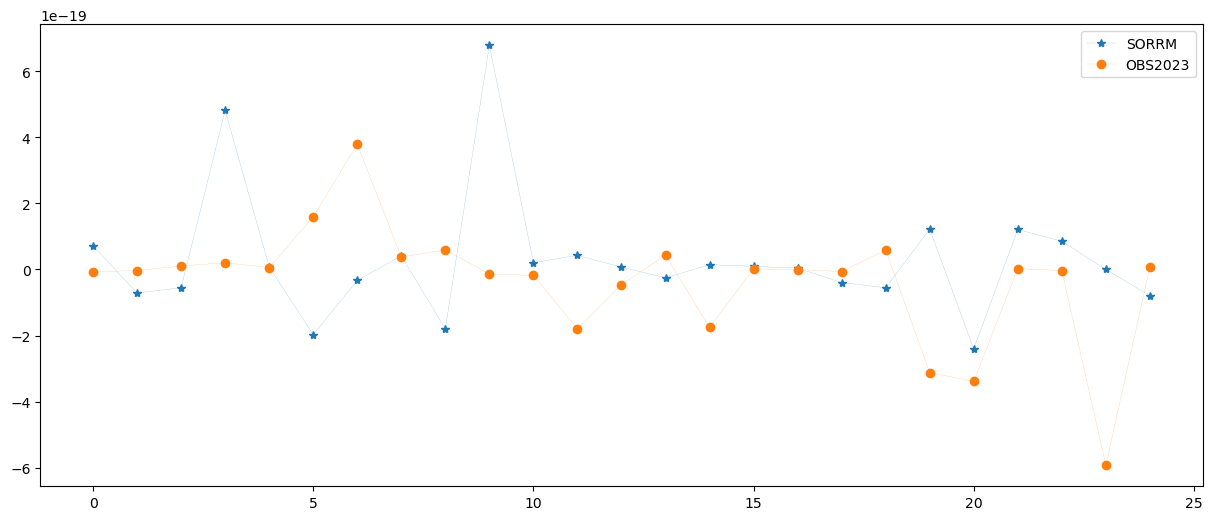

In [29]:
plt.figure(figsize=(15,6))
#my_xticks = icems.name[6:33]
#plt.xticks(range(0,27), my_xticks)
plt.plot(ds_sorrm[1:-1],marker='*',lw=0.1,label='SORRM')
plt.plot(ds_obsrv[1:-1],marker='o',lw=0.1,label='OBS2023')
plt.legend()
#plt.xlabel("SORRMv2.1")
#plt.ylabel("OBS2023")
#plt.xlim(-0.0001,0.0001)
#plt.ylim(-0.0001,0.0001)
#plt.xscale('log')
#plt.yscale('log')

#plt.xlim(-4e-19,4e-19)
#plt.ylim(-4e-19,4e-19)

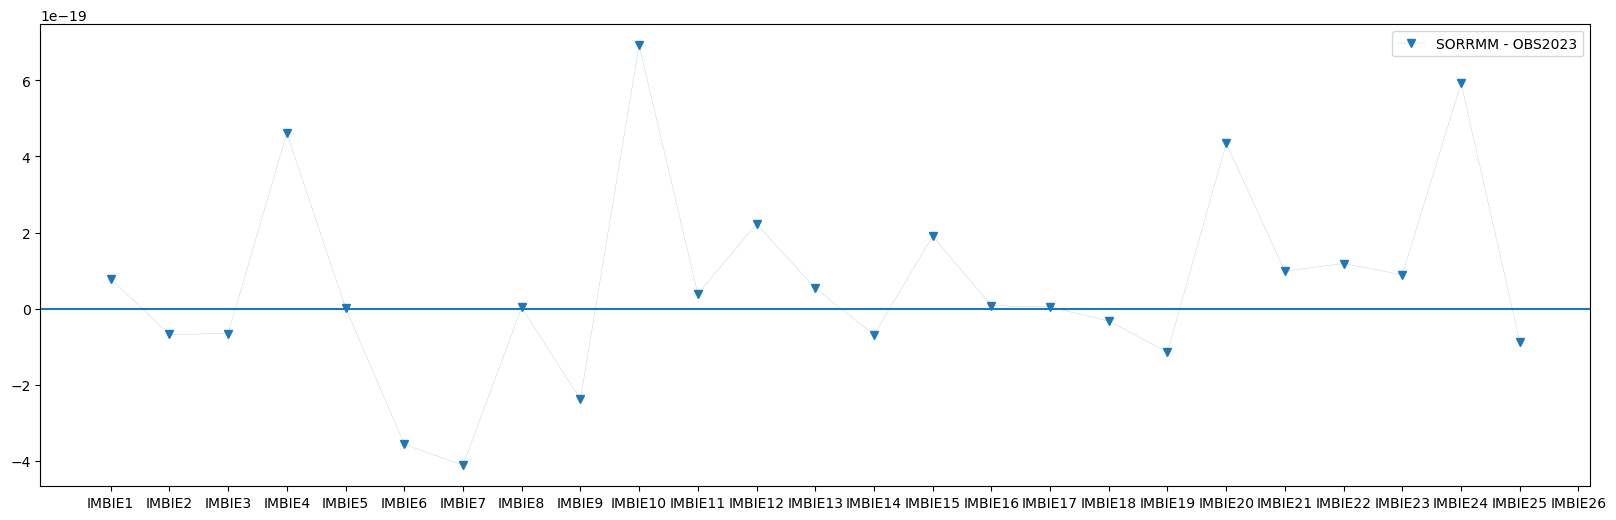

In [101]:
plt.figure(figsize=(20,6))
my_xticks = icems.name[6:33]
plt.xticks(range(0,27), my_xticks)
#plt.plot(ds_sorrm[1:-1],marker='*',lw=0.1,label='SORRM')
#plt.plot(ds_obsrv[1:-1],marker='o',lw=0.1,label='OBS2023')
#plt.plot((ds_sorrm[1:-1]-ds_obsrv[1:-1])/ds_obsrv[1:-1], marker='v',lw=0.1,label='ERROR')
plt.plot((ds_sorrm[1:-1]-ds_obsrv[1:-1]), marker='v',lw=0.1,label='SORRMM - OBS2023')
plt.legend()
plt.axhline(0)
#plt.axhline(5)
#plt.axhline(-5)
#plt.xlabel("SORRMv2.1")
#plt.ylabel("OBS2023")
#plt.xlim(-0.0001,0.0001)
#plt.ylim(-0.0001,0.0001)
#plt.xscale('log')
#plt.yscale('log')

#plt.xlim(-4e-19,4e-19)
#plt.ylim(-4e-19,4e-19)

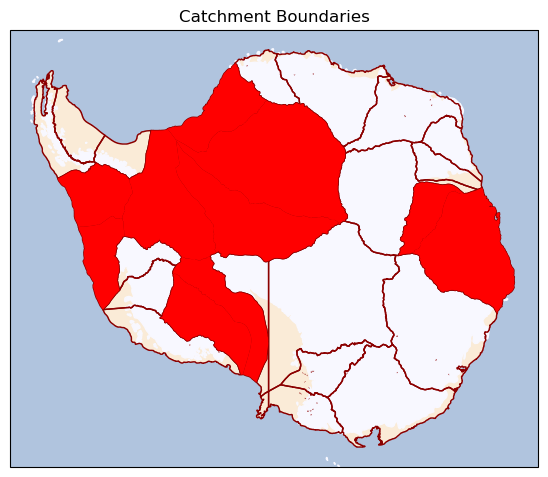

In [80]:
# Plot boundaries

plt.figure(figsize=(15,15))
ax1 = plt.subplot(121,projection=ccrs.SouthPolarStereo())
#ax1.gridlines(color='whitesmoke',zorder=4)
icems[6:33].plot(ax=ax1,color='antiquewhite', linewidth=0,zorder=1)
icems[6:33].boundary.plot(ax=ax1,color='darkred', linewidth=1,zorder=3)
icems[6:10].plot(ax=ax1,color='red', linewidth=0,zorder=4) # IMBIE 1,2 ~ Filchner-Ronne
icems[16:18].plot(ax=ax1,color='red', linewidth=0,zorder=4) # IMBIE 10, 11 ~ Amery
icems[23:25].plot(ax=ax1,color='red', linewidth=0,zorder=4) # IMBIE 17, 18 ~ Ross
icems[28:30].plot(ax=ax1,color='red', linewidth=0,zorder=4) # IMBIE 22, 23 ~ Thwaites
ax1.patch.set_facecolor(color='lightsteelblue')
#ax1.add_feature(cartopy.feature.LAND, color='ghostwhite')
ax1.add_feature(cartopy.feature.LAND, color='ghostwhite', zorder=2)
plt.title('Catchment Boundaries');

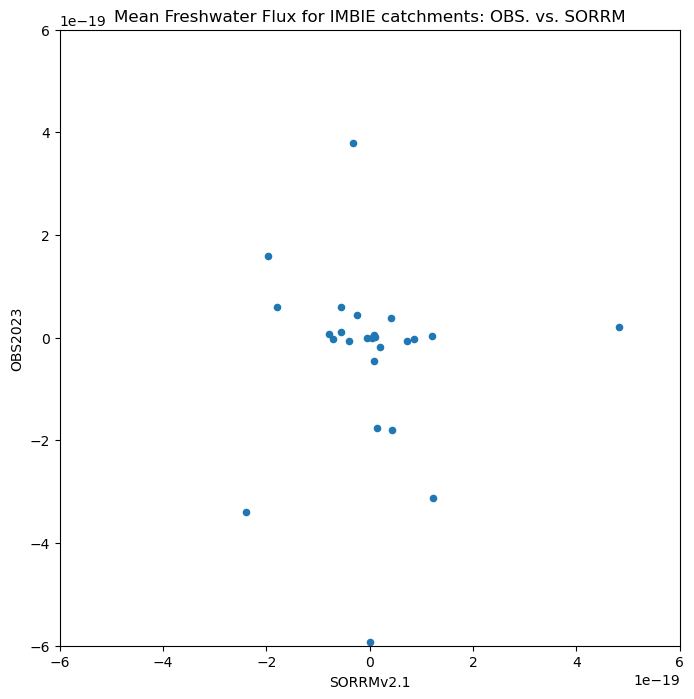

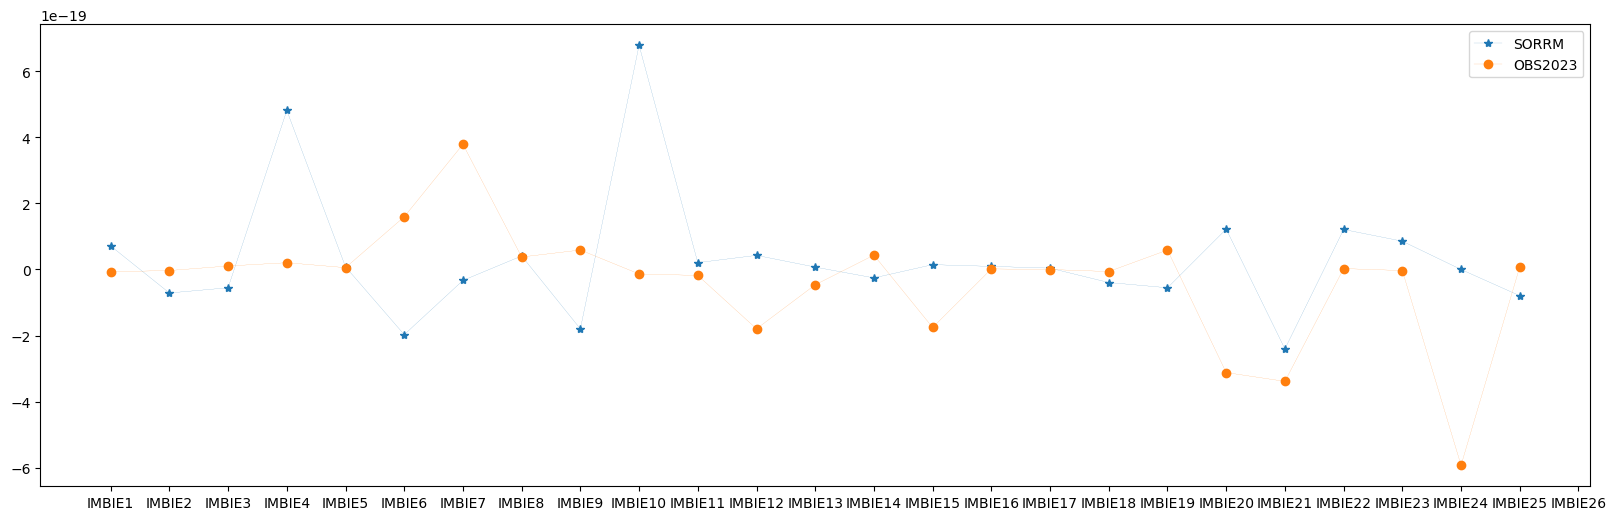

In [53]:
plt.figure(figsize=(8,8))
plt.scatter(ds_sorrm, ds_obsrv, s=20)
plt.xlabel("SORRMv2.1")
plt.ylabel("OBS2023")
#plt.xlim(-0.0001,0.0001)
#plt.ylim(-0.0001,0.0001)
#plt.xscale('log')
#plt.yscale('log')

plt.title("Mean Freshwater Flux for IMBIE catchments: OBS. vs. SORRM")
plt.xlim(-6e-19,6e-19)
plt.ylim(-6e-19,6e-19)


plt.figure(figsize=(20,6))
my_xticks = icems.name[6:33]
plt.xticks(range(0,27), my_xticks)
plt.plot(ds_sorrm[1:-1],marker='*',lw=0.1,label='SORRM')
plt.plot(ds_obsrv[1:-1],marker='o',lw=0.1,label='OBS2023')
plt.legend()
#plt.xlabel("SORRMv2.1")
#plt.ylabel("OBS2023")
#plt.xlim(-0.0001,0.0001)
#plt.ylim(-0.0001,0.0001)
#plt.xscale('log')
#plt.yscale('log')

#plt.xlim(-4e-19,4e-19)
#plt.ylim(-4e-19,4e-19)

In [22]:
ds_np_dedrafted = np.load(inDirName+DIR_interim+"Paolo2023/imbie_iceshelf_mean_fluxrates.npy")

In [ ]:
flux_clean = xr.open_dataset(inDirName+DIR_interim+

In [107]:
r = np.corrcoef(ds_obsrv[5:-5], ds_sorrm[5:-5])
r

array([[ 1.        , -0.05779421],
       [-0.05779421,  1.        ]])

In [10]:
# IMBIE ice shelves = 6 to 32
for i,isnum in enumerate(range(6,33)):
    print(i,isnum)

0 6
1 7
2 8
3 9
4 10
5 11
6 12
7 13
8 14
9 15
10 16
11 17
12 18
13 19
14 20
15 21
16 22
17 23
18 24
19 25
20 26
21 27
22 28
23 29
24 30
25 31
26 32


In [ ]:
# Save linear regression interim files for MELT_OBS and SORRMv21

In [ ]:
# Plot dedrafted melt for MELT_OBS and SORRMv21 across ice shelves.
# To save time, can use IMBIE definitions of ice shelves at first - 
# these are larger catchments with mostly similar behavior as the 
# refined catchment definitions of individual ice shelves

In [ ]:
# Compare PAOLO23 to SORRMv21
# Spatiotemporal means in a scatterplot

In [75]:
MELTDRAFT_OBS.melt.attrs

{'units': 'm of ice per year',
 'standard_name': 'ice shelf basal melt rate',
 'density': 917.0,
 'density_units': 'kg m^-3',
 'grid_mapping': 'mapping'}

In [49]:
# Refer Paolo 2023, or captoolkit
# Lines 260-261 in 
# https://github.com/nasa-jpl/captoolkit/blob/be9aa159f2eec912e55d7b031f16ac026c8bd045/captoolkit/cubethick.py#L260C66-L260C66

# D = (1 - (rho_ocean - rho_ice) / rho_ocean) H

# H_draft = H_freeb * ((rho_ocean / (rho_ocean - rho_ice)) - 1)
# H = H_freeb * rho_ocean / (rho_ocean - rho_ice)

H = melt.thickness
rho_ocean = 1028.0
rho_ice = 917.0
H_draft = (H*(rho_ocean-rho_ice)/rho_ocean)*((rho_ocean / (rho_ocean - rho_ice)) - 1)
melt['draft'] = H_draft


# xarray raises an issue when saving the modified dataset with just the melt and draft variables, 
# delete grid_mapping attribute to proceed with writing the file
# del ds.melt.attrs['grid_mapping']

ds1 = melt.melt
ds2 = melt.draft
ds = xr.merge([ds1,ds2])
ds.to_netcdf(inDirName+DIR_basalMeltObs+'ANT_G1920V01_IceShelfMeltDraft.nc')

In [76]:
mlt = melt.melt.rio.clip(icems.loc[[i],'geometry'].apply(mapping),icems.crs,drop=False)
mlt_mean = mlt.mean('time')
#h = ds.timeMonthly_avg_ssh
#h_mean = h.mean('time')
# Dedraft: Linear Regression with SSH over chosen basin
print('calculating linear regression for catchment {}'.format(icems.name.values[i]))
mlt_rgrs = xr_linregress(h, mlt_mean, dim='time') # h = independent variable
mlt_prd = mlt_rgrs.slope*h_mean + mlt_rgrs.intercept
#flx_ddrft = flx - flx_prd

calculating linear regression for catchment IMBIE1


In [ ]:
# Merge regression files of individual ice shelves

ds_np = np.empty(SORRMv21.timeMonthly_avg_landIceFreshwaterFlux[0].shape)
ds_np[:] = np.nan

ICESHELF_RGRS = xr.DataArray(ds_np, 
                             coords=SORRMv21.timeMonthly_avg_landIceFreshwaterFlux[0].coords, 
                             dims = SORRMv21.timeMonthly_avg_landIceFreshwaterFlux[0].dims, 
                             attrs=SORRMv21.timeMonthly_avg_landIceFreshwaterFlux.attrs)
#iceshelves_rgrs = xr.Dataset(data_vars=dict(timeMonthly_avg_landIceFreshwaterFlux=(iceshelves_rgrs_array)), coords=data.coords, attrs=data.timeMonthly_avg_landIceFreshwaterFlux.attrs)
ICESHELF_RGRS = xr.Dataset(data_vars=dict(timeMonthly_avg_landIceFreshwaterFlux=(ICESHELF_RGRS)))

for i in range(6,33):
    iceshelves_rgrs_catchment = xr.open_dataset(inDirName+DIR_SORRMv21_Interim+'{}_rgrs.nc'.format(icems.name.values[i]))
    iceshelves_rgrs_catchment['timeMonthly_avg_landIceFreshwaterFlux'] = iceshelves_rgrs_catchment['__xarray_dataarray_variable__']
    iceshelves_rgrs_catchment = iceshelves_rgrs_catchment.drop(['__xarray_dataarray_variable__'])
    ICESHELF_RGRS = xr.merge([ICESHELF_RGRS, iceshelves_rgrs_catchment], compat='no_conflicts')

ICESHELF_RGRS.to_netcdf(inDirName+DIR_SORRMv21_Interim+"ICESHELVES_AIS_RGRS.nc")

# Dedraft data

DEDRAFTED_SORRM = SORRMv21.timeMonthly_avg_landIceFreshwaterFlux - ICESHELF_RGRS.timeMonthly_avg_landIceFreshwaterFlux
DEDRAFTED_SORRM = xr.Dataset(data_vars=dict(timeMonthly_avg_landIceFreshwaterFlux=(DEDRAFTED_SORRM)))
DEDRAFTED_SORRM.to_netcdf(inDirName+DIR_interim+"SORRMv2.1./DEDRAFTED_SORRM.nc")

extracting data for catchment IMBIE1
calculating linear regression for catchment IMBIE1
IMBIE1 file saved
deleted interim variables
extracting data for catchment IMBIE2
calculating linear regression for catchment IMBIE2
IMBIE2 file saved


NameError: name 'ds' is not defined

In [85]:
# Scatterplots of slope of ice shelves in Paolo vs. SORRM
# Scatterplots of ice shelf spatiotemporal means in dedrafted version

'data/interim/Paolo2023/iceShelves_dedraft/'